## Analyzing the effect of weather on policing

In this chapter, you will use a second dataset to explore the impact of weather conditions on police behavior during traffic stops. You will practice merging and reshaping datasets, assessing whether a data source is trustworthy, working with categorical data, and other advanced skills.

              TMIN         TAVG         TMAX
count  4017.000000  1217.000000  4017.000000
mean     43.484441    52.493016    61.268608
std      17.020298    17.830714    18.199517
min      -5.000000     6.000000    15.000000
25%      30.000000    39.000000    47.000000
50%      44.000000    54.000000    62.000000
75%      58.000000    68.000000    77.000000
max      77.000000    86.000000   102.000000


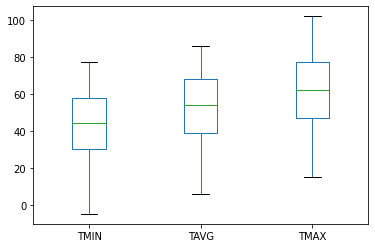

In [3]:
# Import the pandas library as pd
import pandas as pd
import matplotlib.pyplot as plt 

# Read 'police.csv' into a DataFrame named ri
weather = pd.read_csv('Weather in Providence, Rhode Island.csv')

# Describe the temperature columns
print(weather[['TMIN','TAVG','TMAX']].describe())

# Create a box plot of the temperature columns
weather[['TMIN','TAVG','TMAX']].plot(kind='box')

# Display the plot
plt.show()

### Plotting the temperature difference
In this exercise, you'll continue to assess whether the dataset seems trustworthy by plotting the difference between the maximum and minimum temperatures.

What do you notice about the resulting histogram? Does it match your expectations, or do you see anything unusual?

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


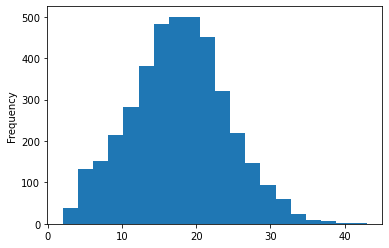

In [4]:
# Create a 'TDIFF' column that represents temperature difference
weather['TDIFF'] = weather['TMAX'] - weather['TMIN']

# Describe the 'TDIFF' column
print(weather['TDIFF'].describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
weather['TDIFF'].plot(kind= 'hist',bins = 20)

# Display the plot
plt.show()

### Counting bad weather conditions
The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

1. WT05 indicates "Hail"
2. WT11 indicates "High or damaging winds"
3. WT17 indicates "Freezing rain"

For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

In this exercise, you'll quantify "how bad" the weather was each day by counting the number of 1 values in each row.

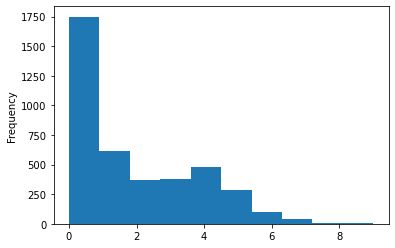

In [6]:
# Copy 'WT01' through 'WT22' to a new DataFrame
WT = weather.loc[:, 'WT01':'WT22']

# Calculate the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
weather.bad_conditions.plot(kind='hist')

# Display the plot
plt.show()

### Rating the weather conditions
In the previous exercise, you counted the number of bad weather conditions each day. In this exercise, you'll use the counts to create a rating system for the weather.

The counts range from 0 to 9, and should be converted to ratings as follows:

1. Convert 0 to 'good'
2. Convert 1 through 4 to 'bad'
3. Convert 5 through 9 to 'worse'

In [7]:
# Count the unique values in 'bad_conditions' and sort the index
print(weather.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad',3:'bad',4:'bad', 5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather['rating'].value_counts())

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
bad      1836
good     1749
worse     432
Name: rating, dtype: int64


### Preparing the DataFrames
In this exercise, you'll prepare the traffic stop and weather rating DataFrames so that they're ready to be merged:

1. With the ri DataFrame, you'll move the stop_datetime index to a column since the index will be lost during the merge.
2. With the weather DataFrame, you'll select the DATE and rating columns and put them in a new DataFrame.

In [20]:
# Read 'police.csv' into a DataFrame named ri
ri = pd.read_csv('Traffic stops in Rhode Island.csv', index_col = 'stop_date')

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = weather[['DATE','rating']]

# Examine the head of 'weather_rating'
print(weather_rating.head())

       DATE rating
0  1/1/2005    bad
1  1/2/2005    bad
2  1/3/2005    bad
3  1/4/2005    bad
4  1/5/2005    bad


### Merging the DataFrames
In this exercise, you'll merge the ri and weather_rating DataFrames into a new DataFrame, ri_weather.

The DataFrames will be joined using the stop_date column from ri and the DATE column from weather_rating. Thankfully the date formatting matches exactly, which is not always the case!

In [23]:
# Examine the shape of 'ri'
print(ri.shape)

# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Examine the shape of 'ri_weather'
print(ri_weather.shape)


(70921, 14)
(70921, 16)


### Comparing arrest rates by weather rating
Do police officers arrest drivers more often when the weather is bad? Find out below!

First, you'll calculate the overall arrest rate.
Then, you'll calculate the arrest rate for each of the weather ratings you previously assigned.

Finally, you'll add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate.

Since you previously defined a logical order for the weather categories, good < bad < worse, they will be sorted that way in the results.

In [24]:
# Calculate the overall arrest rate
print(ri_weather.is_arrested.mean())

0.037221104471337196


In [27]:
# Calculate the arrest rate for each 'rating'
print(ri_weather.groupby('rating').is_arrested.count())

rating
bad      31415
good     27459
worse     7728
Name: is_arrested, dtype: int64


In [28]:
# Calculate the arrest rate for each 'violation' and 'rating'
print(ri_weather.groupby(['violation','rating']).is_arrested.count())

violation            rating
Equipment            bad        3682
                     good       3013
                     worse       719
Moving violation     bad        6111
                     good       5212
                     worse      1488
Other                bad        1693
                     good       1426
                     worse       636
Registration/plates  bad        1201
                     good       1021
                     worse       320
Seat belt            bad         156
                     good        214
                     worse         5
Speeding             bad       18572
                     good      16573
                     worse      4560
Name: is_arrested, dtype: int64


### Selecting from a multi-indexed Series
The output of a single .groupby() operation on multiple columns is a Series with a MultiIndex. Working with this type of object is similar to working with a DataFrame:

1. The outer index level is like the DataFrame rows.
2. The inner index level is like the DataFrame columns.

In this exercise, you'll practice accessing data from a multi-indexed Series using the .loc[] accessor.

In [29]:
# Save the output of the groupby operation from the last exercise
arrest_rate = ri_weather.groupby(['violation', 'rating']).is_arrested.count()

# Print the 'arrest_rate' Series
print(arrest_rate)

# Print the arrest rate for moving violations in bad weather
print(arrest_rate.loc['Moving violation', 'bad'])

# Print the arrest rates for speeding violations in all three weather conditions
print(arrest_rate.loc['Speeding'])

violation            rating
Equipment            bad        3682
                     good       3013
                     worse       719
Moving violation     bad        6111
                     good       5212
                     worse      1488
Other                bad        1693
                     good       1426
                     worse       636
Registration/plates  bad        1201
                     good       1021
                     worse       320
Seat belt            bad         156
                     good        214
                     worse         5
Speeding             bad       18572
                     good      16573
                     worse      4560
Name: is_arrested, dtype: int64
6111
rating
bad      18572
good     16573
worse     4560
Name: is_arrested, dtype: int64


### Reshaping the arrest rate data
In this exercise, you'll start by reshaping the arrest_rate Series into a DataFrame. This is a useful step when working with any multi-indexed Series, since it enables you to access the full range of DataFrame methods.

In [31]:
# Unstack the 'arrest_rate' Series into a DataFrame
print(arrest_rate.unstack())

rating                 bad   good  worse
violation                               
Equipment             3682   3013    719
Moving violation      6111   5212   1488
Other                 1693   1426    636
Registration/plates   1201   1021    320
Seat belt              156    214      5
Speeding             18572  16573   4560
